<div align="center">

# <span style="color: #3498db;">CA2 - Genetic & Game</span>

**<span style="color:rgb(247, 169, 0);">Erfan Falahati</span> - <span style="color:rgb(143, 95, 195);">810102491</span>**

</div>


<div style="font-family: Arial, sans-serif; line-height: 1.6;">

### 📊 Matplotlib – Data Visualization in Python  

matplotlib is a python library that is mainly used for data visualization. This library allows you to plot different type of figures including scatters and histograms. In the first part of this project you are supposed to implement a genetic algorithm. To visualize plots that are required in the project description use plotting as much as you can because it gives a great insight on what is happening during each run. It also helps you to compare your results whenevever you want to understand effect of different parameters during different runs.
For more information, check [this notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.00-Introduction-To-Matplotlib.ipynb) and visit [the website](https://matplotlib.org/stable/tutorials/pyplot.html#sphx-glr-tutorials-pyplot-py).

In [20]:
import matplotlib.pyplot as plt

# <span style="color: #3498db;">Genetic Algorithm</span>

In [21]:
import random
import itertools
import numpy as np

In [22]:
# algorithm parameters
numCoeffs = 43
coeffsRange = (-5, +5)
populationSize = 100
generations = 50
mutationRate = 0.15
crossoverRate = 0.8
eliteCount = 5
functionRange = (-np.pi, np.pi)
sampleCount = 100

In [23]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction
    

<div style="color:rgb(235, 66, 32); font-weight: bold;">⚠️ Important Note:</div>  

Using **NumPy arrays** allows you to perform operations on vectors **more efficiently** and **faster**.

**Avoid using `for` loops** whenever possible, as vectorized operations in NumPy are **optimized for performance** and significantly reduce execution time.  


**sampling from coeffRange to struct a population**

In [24]:
def fourier_series(t, coefficients):
    a0 = coefficients[0]
    sum_terms = a0 / 2
    for n in range(1, 22):
        an = coefficients[n]
        bn = coefficients[n + 21]
        sum_terms += an * np.cos(n * t) + bn * np.sin(n * t)
    return sum_terms

def FitnessScore(population: np.array, tSamples, fSamples, method: str):
    fitness_score = []
    def RMSE(predicted, samples):
        return np.sqrt(np.mean((samples - predicted) ** 2))
    
    def MSE(predicted, samples):            
        return np.mean((samples - predicted) ** 2)
    
    def MAE(predicted, samples):
        return np.mean(np.absolute(samples - predicted))
    
    def R2(predicted, samples):
        ss_res = np.sum((samples - predicted) ** 2)
        ss_tot = np.sum((samples - np.mean(samples)) ** 2)
        if ss_tot == 0:
            return 1.0 if ss_res == 0 else 0.0 
        return 1 - (ss_res / ss_tot)
    
    score_methods = {
        'rmse': RMSE,
        'mse': MSE,
        'mae': MAE,
        'r2': R2,
    }
    
    for individual in population:
        approximated = fourier_series(tSamples, individual)
        score = score_methods.get(method.lower())(approximated, fSamples)
        fitness_score.append(1/(score + 1) if method.lower() != 'r2' else score)
    return np.array(fitness_score)

**Next Generation**

In [25]:
def select_parents(population: np.array, fitness_scores: np.array, tSamples, fSamples, selection_method: str, score_method: str, tournament_size=3):
    def tournament():
        indices = np.random.choice(population.shape[0], size=tournament_size, replace=False)
        candidates = population[indices]
        fitnesses = FitnessScore(candidates, tSamples, fSamples, score_method)
        best_index = np.argmax(fitnesses)
        return candidates[best_index]
    
    def roulette():
        total_fitness = np.sum(fitness_scores)
        probabilities = fitness_scores / total_fitness
        selected_index = np.random.choice(population.shape[0], p=probabilities)
        return population[selected_index]
    
    method = {
        'tournament': tournament,
        'roulette': roulette,
    }
    
    parent1 = method.get(selection_method.lower())()
    parent2 = method.get(selection_method.lower())()

    return parent1, parent2

def crossover(parent1, parent2, rate=crossoverRate):
    if np.random.random() > rate:
        return parent1.copy(), parent2.copy()
    point = np.random.randint(1, 43)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

def mutate(genotype, rate=mutationRate):
    mutation_mask = np.random.rand(len(genotype)) < rate
    genotype[mutation_mask] = np.random.uniform(coeffsRange[0], coeffsRange[1])
    return genotype

def create_new_generation(population: np.array, tSamples, fSamples, fitness_scores: np.array, score_metod: str, selection_method: str):
    new_population = []
    
    elite_indices = np.argsort(fitness_scores)[-eliteCount:] 
    for idx in elite_indices: 
        elite = population[idx].copy()
        new_population.append(elite)
        
    while len(new_population) < populationSize:
        parent1, parent2 = select_parents(population,fitness_scores, tSamples, fSamples, selection_method, score_metod)
        child1, child2 = crossover(parent1, parent2)

        child1 = mutate(child1)
        child2 = mutate(child2)
        
        new_population.extend([child1, child2])

    return np.array(new_population[:populationSize])


***Gen Algorithem***

In [26]:
def genetic_algorithm(generations, tSamples, fSamples, score_method='rmse', selection_method='tournament'):
    population = np.random.uniform(coeffsRange[0], coeffsRange[1], size=(populationSize, 43))
    best_fitness_history = []
    
    for _ in range(generations):
        fitness_scores = FitnessScore(population, tSamples, fSamples, score_method)
        best_idx = np.argmax(fitness_scores)
        best_fitness_history.append(fitness_scores[best_idx])
        population = create_new_generation(population, tSamples, fSamples, fitness_scores, score_method, selection_method)

    final_fitnesses = FitnessScore(population, tSamples, fSamples, score_method)
    best_idx = np.argmax(final_fitnesses)

    return population[best_idx], best_fitness_history

KeyboardInterrupt: 

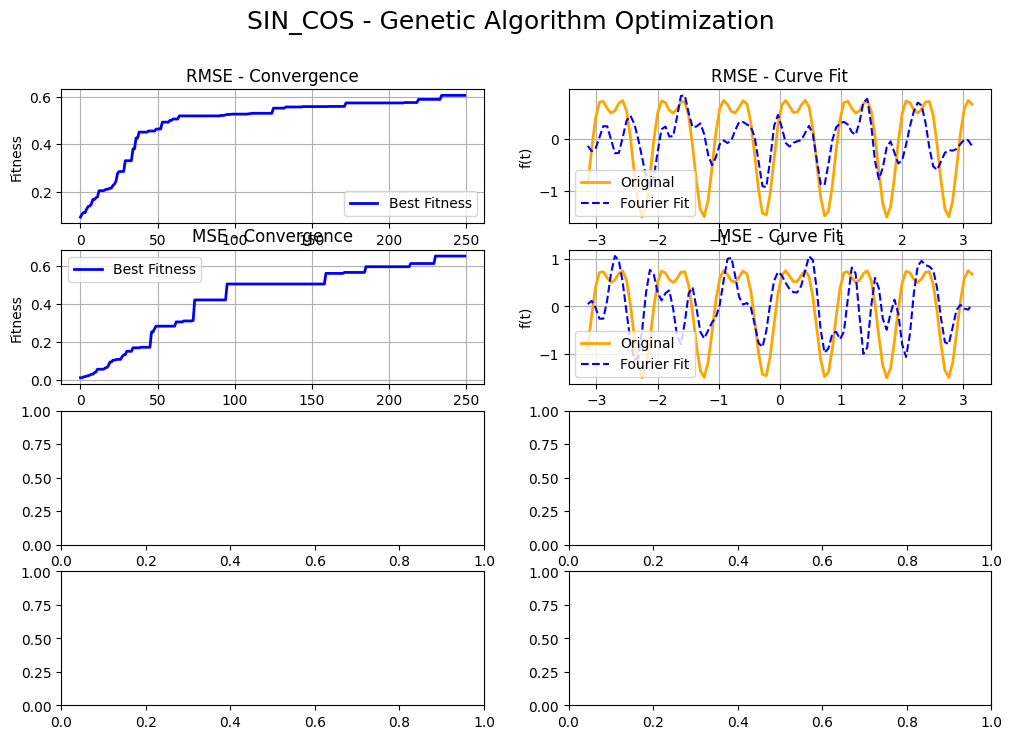

In [27]:
import matplotlib.pyplot as plt

periodic = ["sin_cos", "gaussian", "square_wave", "sawtooth", "complex_fourier"]
non_periodic = ["cubic", "quadratic", "linear",  "polynomial"]
for testFunc in periodic + non_periodic:
    tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
    fSamples = getTargetFunction(testFunc)(tSamples)
    
    coeffsRange = (-500, 500) if testFunc in non_periodic else (-5, 5)
    # coeffsRange = ((np.min(np.abs(fSamples))), np.max(np.abs(fSamples)))

    fig, axes = plt.subplots(4, 2, figsize=(12, 8))
    fig.suptitle(f"{testFunc.upper()} - Genetic Algorithm Optimization", fontsize=18)

    for i, method in enumerate(['rmse', 'mse', 'mae', 'r2']):
        best_solution, fitness_history = genetic_algorithm(250, tSamples, fSamples, score_method=method)

        axes[i, 0].plot(fitness_history, label="Best Fitness", color='blue', linewidth=2)
        axes[i, 0].set_title(f"{method.upper()} - Convergence")
        axes[i, 0].set_xlabel("Generation")
        axes[i, 0].set_ylabel("Fitness")
        axes[i, 0].grid(True)
        axes[i, 0].legend()

        axes[i, 1].plot(tSamples, fSamples, label="Original", color='orange', linewidth=2)
        axes[i, 1].plot(tSamples, fourier_series(tSamples, best_solution), label="Fourier Fit", color='blue', linestyle='--')
        axes[i, 1].set_title(f"{method.upper()} - Curve Fit")
        axes[i, 1].set_xlabel("t")
        axes[i, 1].set_ylabel("f(t)")
        axes[i, 1].grid(True)
        axes[i, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    plt.close()


# <span style="color: red;"> Q&A 1</span> 

---

### <span style="color: #20B2AA;">Question #1</span>
The state space has an infinite number of states due to the continuity of the range.

### <span style="color: #20B2AA;">Question #2</span>

**Method 1:** Keep the best genotypes to transfer to subsequent generations.  
**Method 2:** Form a better initial population with higher fitness in the first generation.

### <span style="color: #20B2AA;">Question #3</span>

**Tournament Method:** A number of chromosomes are randomly selected from the population, and the best chromosome is chosen as a parent.  
**Roulette Wheel Method:** The probability of selecting each chromosome is proportional to its fitness.

### <span style="color: #20B2AA;">Question #4</span>

**Method 1:** By increasing the mutation rate, new genes can be generated to prevent premature convergence.  
**Method 2:** Use the island model (having multiple separate mating pools and performing migration between them).


### <span style="color: #20B2AA;">Question #5</span>

R-squared (R2) is defined as a number that tells you how well the independent variable(s) in a statistical model explains the variation in the dependent variable. It ranges from 0 to 1, where 1 indicates a perfect fit of the model to the data.

**R-squared (R²) Formula:**
$$R^2 = 1 - \frac{Unexplained Variation}{Total Variation} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}\$$

Where:
- $y_i$ : actual value  
- $\hat{y}_i$ : predicted value  
- $\bar{y}$ : mean of actual values  
- n : number of data points


# <span style="color: #3498db;">Minmax Algorithm</span>

In [ ]:
import random
import numpy as np
from math import inf
import time
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
class PentagoGame:
    def __init__(self, ui=False, print=False, depth=2, puning=True):
        self.board = np.zeros((6, 6), dtype=int)
        self.current_player = 1
        self.ui = ui
        self.depth = depth
        self.nodes_visited = 0
        self.total_node_visited = 0
        self.game_over = False
        self.result = None
        self.selected_block = None  
        self.move_stage = 0  # 0: place piece, 1: select block, 2: rotate
        self.temp_piece = None
        self.print = print
        self.puning = puning

        if ui:
            pygame.font.init()
            self.screen = pygame.display.set_mode((800, 600))
            pygame.display.set_caption("Pygame Board")
            # self.font = pygame.font.SysFont("Arial", 20)
            self.show_buttons = False
            self.buttons = {
                "rotate_cw": pygame.Rect(650, 200, 100, 50),
                "rotate_ccw": pygame.Rect(650, 300, 100, 50),
            }
            self.setup_controls()
            self.draw_board()

    def setup_controls(self):
        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])   # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.screen.draw_text("CLOCKWISE", self.buttons["rotate_cw"].center)
            self.screen.draw_text("COUNTER-CLOCKWISE", self.buttons["rotate_ccw"].center)



    def hide_rotation_buttons(self):
        self.show_buttons = False

    def show_rotation_buttons(self):
        self.show_buttons = True

    def copy_board(self, board):
        return np.copy(board)

    def rotate_block(self, board, block, direction):
        row_start = (block // 2) * 3
        col_start = (block % 2) * 3
        sub = board[row_start : row_start + 3, col_start : col_start + 3]
        rotated = np.rot90(sub, 3 if direction == "cw" else 1)
        board[row_start : row_start + 3, col_start : col_start + 3] = rotated

    def get_possible_moves(self, board, player):
        moves = []
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    for block in range(4):
                        for dir in ["cw", "ccw"]:
                            moves.append((i, j, block, dir))
        return moves

    def apply_move(self, board, move, player):
        new_board = self.copy_board(board)
        row, col, block, direction = move
        if new_board[row][col] != 0:
            return None
        new_board[row][col] = player
        self.rotate_block(new_board, block, direction)
        return new_board

    def check_winner(self, board):
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue

                # Horizontal
                if j <= 1 and np.all(board[i, j : j + 5] == board[i][j]):
                    return board[i][j]

                # Vertical
                if i <= 1 and np.all(board[i : i + 5, j] == board[i][j]):
                    return board[i][j]

                # Diagonal
                if (
                    i <= 1
                    and j <= 1
                    and all(board[i + k][j + k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]

                # Anti-diagonal
                if (
                    i <= 1
                    and j >= 4
                    and all(board[i + k][j - k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]
        if np.all(board != 0):
            return 0
        return None
    
    
    
    def evaluate_score(self, board: np.array, player: int):
        score = 0
        score_method = {
            -1: {4: 100, 3: 10, 2: 2},
            1: {4: -80, 3: -8, 2: -1 }
        }
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue
                
                for dx, dy in [(1,0), (0,1), (1,-1), (1,1)]:
                    n_BacktoBack = 1
                    for k in range(1,4+1):
                        x, y = i*dx , j*dy
                        if (0 <= x < 6) and (0 <= y < 6) and board[x][y] == board[i][j]:
                            n_BacktoBack += 1
                        else:
                            break
                if n_BacktoBack < 5:
                    score += score_method[board[i][j]][n_BacktoBack]

        for i,j in [(2,2), (2,3), (3,2), (3,3)]:
            if(board[i][j] == 1):
                score -= 1
            elif(board[i][j] == -1):
                score += 1

        return score if player == -1 else -score

            

    def minimax(self, board: np.array, depth: int, isMaximizingPlayer: bool, alpha=-inf, beta=inf):
        if self.game_over:
            return 0
        
        winner = self.check_winner(board)
        if winner != None or depth == 0:
            if winner == -1: 
                return 1000 
            elif winner == 1:
                return -1000 
            elif winner == 0:
                return 0
            else:
                return self.evaluate_score(board, -1 if isMaximizingPlayer else 1)

        self.nodes_visited += 1

        if isMaximizingPlayer:
            bestScore = -inf
            moves = self.get_possible_moves(board, -1)
            for move in moves:
                new_board = self.apply_move(board, move, -1)
                if new_board is None:
                    continue
                score = self.minimax(new_board, depth-1, False, alpha, beta)
                bestScore = max(score, bestScore)
                if self.puning:
                    alpha = max(alpha, bestScore)
                    if beta <= alpha:
                        break 
            return bestScore
        else:
            bestScore = inf
            moves = self.get_possible_moves(board, 1)
            for move in moves:
                new_board = self.apply_move(board, move, 1)
                if new_board is None:
                    continue
                score = self.minimax(new_board, depth-1, True, alpha, beta)
                bestScore = min(score, bestScore)
                if self.puning:
                    beta = min(beta, bestScore)
                    if beta <= alpha:
                        break 
            return bestScore
        

    def heuristic(self, board, move):
        row, col, block, dir = move
        new_board = np.copy(board)
        new_board[row][col] = -1
        self.rotate_block(new_board, block, dir)
        return self.evaluate_score(new_board, -1)
        

    def get_computer_move(self):
        start_time = time.time()
        best_move = None
        best_value = -inf
        alpha = -inf
        beta = inf
        
        moves = self.get_possible_moves(self.board, -1)
        if not moves:
            return None
        
        if self.puning:
            moves.sort(key=lambda move: -self.heuristic(self.board, move))

        for move in moves:
            if self.game_over:
                break
                
            new_board = self.apply_move(self.board, move, -1)
            if new_board is None:
                continue
            
            self.nodes_visited += 1
            value = self.minimax(new_board, self.depth - 1, False, alpha, beta)
            
            if value > best_value:
                best_value = value
                best_move = move
                alpha = max(alpha, best_value)
        
        if self.print:
            print(f"Move took {time.time()-start_time:.2f}s, nodes visited: {self.nodes_visited}")
        self.total_node_visited += self.nodes_visited
        self.nodes_visited = 0
        return best_move
    
    def draw_text(self, text, center_pos, max_width):
        font_size = 24
        font = pygame.font.Font(None, font_size)
        text_surface = font.render(text, True, (0, 0, 0))

        text_width = text_surface.get_width()
        if text_width > max_width:
            scale_factor = max_width / text_width
            new_font_size = int(font_size * scale_factor)
            font = pygame.font.Font(None, new_font_size)
            text_surface = font.render(text, True, (0, 0, 0))

        text_rect = text_surface.get_rect(center=center_pos)
        self.screen.blit(text_surface, text_rect)

    def draw_board(self):
        self.screen.fill((0, 0, 0))

        for i in range(6):
            for j in range(6):
                x0 = j * 100
                y0 = i * 100

                if self.board[i][j] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (x0 + 50, y0 + 50), 40)
                elif self.board[i][j] == -1:
                    pygame.draw.circle(self.screen, (0, 0, 255), (x0 + 50, y0 + 50), 40)

                pygame.draw.rect(self.screen, (255, 255, 255), (x0, y0, 100, 100), 1)

        for i in [3, 6]:
            pygame.draw.line(self.screen, (255, 255, 255), (0, i * 100), (600, i * 100), 3)  # Horizontal
            pygame.draw.line(self.screen, (255, 255, 255), (i * 100, 0), (i * 100, 600), 3)  # Vertical

        # Show rotation buttons if in move_stage 2
        if self.move_stage == 2:
            self.highlight_selected_block()
            self.show_rotation_buttons()

        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])  # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.draw_text(
                "CLOCKWISE",
                self.buttons["rotate_cw"].center,
                self.buttons["rotate_cw"].width,
            )
            self.draw_text(
                "COUNTER-CLOCKWISE",
                self.buttons["rotate_ccw"].center,
                self.buttons["rotate_ccw"].width,
            )

    def click_handler(self, event):
        if self.game_over or self.current_player != 1:
            return

        x, y = event.pos
        if self.move_stage == 0:  # Place piece
            if x > 600:
                return  # clicks on control area
            col = x // 100
            row = y // 100
            if 0 <= row < 6 and 0 <= col < 6 and self.board[row][col] == 0:
                self.temp_piece = (row, col)
                self.board[row][col] = 1
                self.move_stage = 1
                self.draw_board()

        elif self.move_stage == 1:  # Select block
            if x > 600:
                return
            # which block was clicked
            block_x = 0 if x < 300 else 1
            block_y = 0 if y < 300 else 1
            self.selected_block = block_y * 2 + block_x
            self.move_stage = 2
            self.show_rotation_buttons()
            self.highlight_selected_block()

        elif self.move_stage == 2:  # Rotate
            if self.buttons["rotate_cw"].collidepoint(event.pos):
                self.apply_rotation("cw")
            if self.buttons["rotate_ccw"].collidepoint(event.pos):
                self.apply_rotation("ccw")

    def apply_rotation(self, direction):
        self.rotate_block(self.board, self.selected_block, direction)
        self.current_player = -1
        self.move_stage = 0
        self.selected_block = None
        self.temp_piece = None
        self.hide_rotation_buttons()
        self.draw_board()
        pygame.display.flip()
        self.check_game_over()
        pygame.time.delay(1000)
        self.play_computer_move()

    def highlight_selected_block(self):
        colors = [
            (255, 153, 153),
            (153, 255, 153),
            (153, 153, 255),
            (255, 255, 153),
        ]  # RGB colors

        row_start = (self.selected_block // 2) * 3
        col_start = (self.selected_block % 2) * 3

        pygame.draw.rect(
            self.screen,
            colors[self.selected_block],
            (col_start * 100, row_start * 100, 300, 300),
            5,
        )

    def play_computer_move(self):
        move = self.get_computer_move()
        if move and not self.game_over:
            new_board = self.apply_move(self.board, move, -1)
            if new_board is not None:
                self.board = new_board
                self.current_player = 1
                self.draw_board()
                pygame.display.flip()
                self.check_game_over()
            else:
                print("Invalid computer move!")

    def check_game_over(self):
        winner = self.check_winner(self.board)
        if winner is not None:
            self.game_over = True
            self.result = winner
            print("Game over! Result:", winner)
            if self.ui:
                self.show_game_over_message()

    def show_game_over_message(self):
        self.screen.fill((200, 200, 200))
        pygame.draw.rect(self.screen, (255, 255, 255), (100, 200, 500, 200))
        pygame.draw.rect(self.screen, (0, 0, 0), (100, 200, 500, 200), 3)

        # result_text = f"Player {self.result} wins!" if self.result != 0 else "Draw!"
        # text_surface = self.font_large.render(result_text, True, (255, 0, 0))
        # self.screen.blit(text_surface, (250, 250))

        # exit_text = self.font_small.render("Click anywhere to exit", True, (0, 0, 0))
        # self.screen.blit(exit_text, (230, 350))
        pygame.display.flip()

    def play(self):
        if self.ui:
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        self.click_handler(event)
                self.draw_board()
                pygame.display.flip()
            pygame.quit()
            return self.result
        else:
            while not self.game_over:
                self.print_board()
                winner = self.check_winner(self.board)
                if winner is not None:
                    return winner

                if self.current_player == 1:
                    move = random.choice(self.get_possible_moves(self.board, 1))
                else:
                    move = self.get_computer_move()

                self.board = self.apply_move(self.board, move, self.current_player)
                self.current_player *= -1
            return self.result

    def print_board(self):
        if self.print == False:
            return
        print("-" * 25)
        for row in self.board:
            print(" ".join(f"{x:2}" for x in row))
        print("-" * 25)

In [ ]:
if __name__ == "__main__":

    for pune in [False, True]:
        depths = [1, 2, 3]
        for depth in depths:
            if depth == 3 and not pune:
                continue
            numGames = 5
            numWins, numTies, numLosses, duration, visited_nodes = 0, 0, 0, 0, 0
            for _ in range(numGames):
                game = PentagoGame(ui=False, print=False, depth=depth, puning=pune) 
                start_time = time.time()
                result = game.play()
                duration += time.time() - start_time
                visited_nodes += game.total_node_visited
                if result == -1:
                    numWins += 1
                elif result == 0:
                    numTies += 1
                else:
                    numLosses += 1
            
            print(f"depth: {depth}, puning: {pune}:")
            print(f"mean visited nodes: {visited_nodes/numGames}\t mean time: {duration/numGames}\t Wins: {numWins/numGames * 100}%")
            print("*************************************")




depth: 1, puning: False:
mean visited nodes: 0.0	 mean time: 0.10030403137207031	 Wins: 100.0%
*************************************
depth: 2, puning: False:
mean visited nodes: 2025.2	 mean time: 35.24998574256897	 Wins: 80.0%
*************************************
depth: 1, puning: True:
mean visited nodes: 0.0	 mean time: 0.2121936321258545	 Wins: 100.0%
*************************************
depth: 2, puning: True:
mean visited nodes: 1881.8	 mean time: 0.8698531150817871	 Wins: 100.0%
*************************************
depth: 3, puning: True:
mean visited nodes: 13775.6	 mean time: 73.57810235023499	 Wins: 100.0%
*************************************


# <span style="color: red;"> Q&A 2</span>

---

### <span style="color: #20B2AA;">Question #1</span>
**Yes.**
- Time: As the depth increases, the time also increases exponentially.
- Winning Chance: With increased depth, the algorithm is able to predict more of the moves that will be made in the future.
- Visited Nodes: As the depth of the minimax tree increases, the number of visited nodes also increases.

### <span style="color: #20B2AA;">Question #2</span>

**Yes.**

If we can determine the score of the nodes using a specific heuristic and sort them, we can increase the amount of pruning.

### <span style="color: #20B2AA;">Question #3</span>

The average number of child nodes (moves) per node

$${Branching Factor} = \frac{N_{d+1}}{N_d}\$$

- $N_d$ = Number of nodes at depth (d) 
- $N_{d+1}$ = Number of nodes at depth (d + 1)

**Initially**, it has a value of **36 × 8**, and it **decreases** as the game progresses.

### <span style="color: #20B2AA;">Question #4</span>

Pruning prevents the search of depths that do not affect the value chosen by the Minimax algorithm.

This simply avoids unnecessary searches and does not reduce the accuracy of the algorithm, ultimately leading to a reduction in the execution time of the Minimax algorithm.

### <span style="color: #20B2AA;">Question #5</span>

The Minimax algorithm assumes that the opponent always makes the best possible move to harm us.
However, if the opponent acts randomly or by chance, this assumption is not valid.
In this case, Minimax may overestimate the opponent’s behavior pessimistically and make unrealistic decisions, because instead of considering the average outcome of the opponent's moves, it assumes the worst-case scenario.

When facing a random or non-intelligent opponent, the ***Expectimax algorithm*** is a better choice than Minimax, because its decision-making is based on the expected value of outcomes rather than the worst-case scenario.

